# Linear Regression
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*
## Loading data

In [59]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [60]:
df.head()

,wis,int,dex,level,str,cha,book,hp,con,ac
0,2,1,2,10,7,1,Pathfinder Bestiary,215,5,29
1,2,-4,0,10,9,1,Pathfinder Bestiary,220,5,28
2,3,-4,3,8,7,-2,Pathfinder Bestiary,175,6,25
3,5,6,4,17,7,6,Pathfinder Bestiary,315,5,41
4,1,-1,3,1,-5,1,Pathfinder Bestiary,20,1,16


## Preprocessing and train test split

In [61]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[characteristics] = pd.DataFrame(scaler.fit_transform(df[characteristics]))
min_max_df["book"] = df["book"]
min_max_df["level"] = df["level"]

In [62]:
min_max_df.head()

,cha,con,dex,int,str,wis,ac,hp,book,level
0,0.3750,0.416667,0.4375,0.400000,0.705882,0.333333,0.456522,0.386447,Pathfinder Bestiary,10
1,0.3750,0.416667,0.3125,0.066667,0.823529,0.333333,0.434783,0.395604,Pathfinder Bestiary,10
2,0.1875,0.500000,0.5000,0.066667,0.705882,0.416667,0.369565,0.313187,Pathfinder Bestiary,8
3,0.6875,0.416667,0.5625,0.733333,0.705882,0.583333,0.717391,0.569597,Pathfinder Bestiary,17
4,0.3750,0.083333,0.5000,0.266667,0.000000,0.250000,0.173913,0.029304,Pathfinder Bestiary,1


### Chronological split

In [63]:
from training.splitting_dataset import split_dataframe

os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(min_max_df, test_size=0.31)
os.chdir("../notebooks/models/linear_regression")

In [64]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [65]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [66]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(min_max_df, chronological_split=False, test_size=0.25)

In [67]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.98


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MSE test: {mse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.74
RMSE test: 0.95
MSE test: 0.90
MAE test: 0.67


In [70]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", 8, mse, rmse, mae]

###### MAE by level

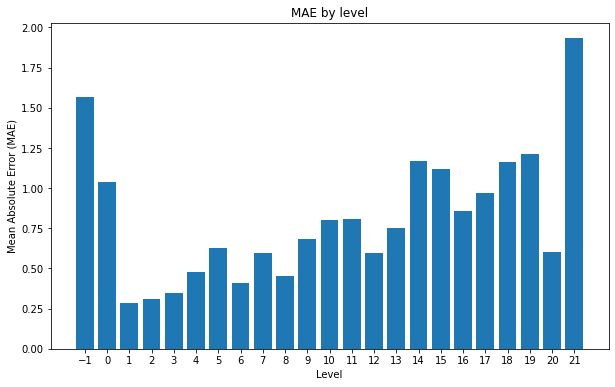

In [71]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [72]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.90
RMSE: 0.95

Round type: round
MSE: 0.85
RMSE: 0.92

Round type: 0.33
MSE: 0.82
RMSE: 0.91

Round type: 0.45
MSE: 0.84
RMSE: 0.92



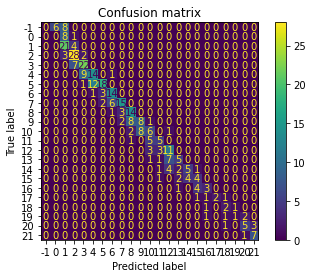

In [73]:
plot_confusion_matrix("round", predict, y_test)

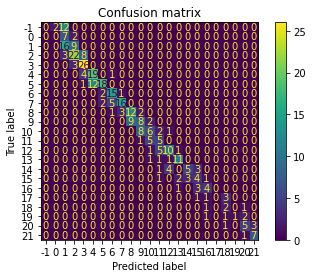

In [74]:
plot_confusion_matrix(0.33, predict, y_test)

### With random split

In [75]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)

y_pred_train_random_split = model.predict(X_train_random_split)
y_pred_test_random_split = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train_random_split)
print(f"R2 score:{r2:.2f}")

R2 score:0.98


In [76]:
rmse_train = mean_squared_error(
    y_train_random_split, y_pred_train_random_split, squared=False
)
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
mse = mean_squared_error(y_test_random_split, y_pred_test_random_split)
mae = mean_absolute_error(y_test_random_split, y_pred_test_random_split)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MSE test: {mse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.79
RMSE test: 0.82
MSE test: 0.68
MAE test: 0.54


In [77]:
results.loc[1] = ["random", "normal", 8, mse, rmse, mae]

###### MAE by level

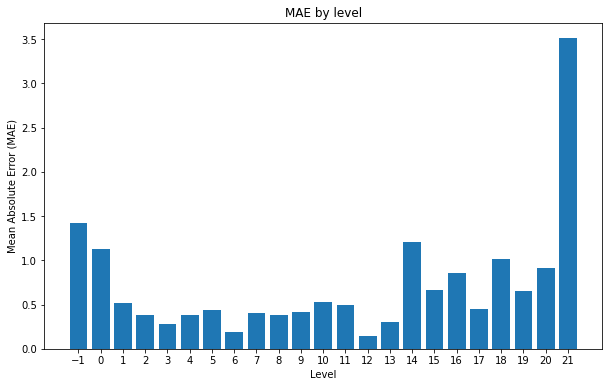

In [78]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test_random_split)[
        y_test_random_split == lvl
    ]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [79]:
check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, y_pred_test_random_split
)

Normal:
MSE: 0.68
RMSE: 0.82

Round type: round
MSE: 0.53
RMSE: 0.73

Round type: 0.33
MSE: 0.56
RMSE: 0.75

Round type: 0.45
MSE: 0.53
RMSE: 0.73



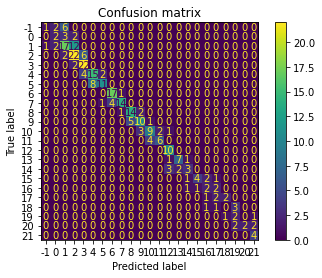

In [80]:
plot_confusion_matrix("round", y_pred_test_random_split, y_test_random_split)

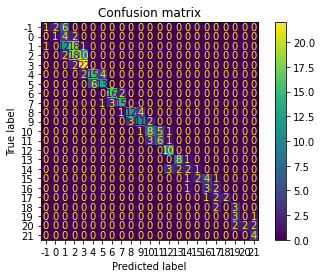

In [81]:
plot_confusion_matrix(0.33, y_pred_test_random_split, y_test_random_split)

## Tuning (ridge, LASSO)

### With chronological split

In [82]:
from sklearn.linear_model import RidgeCV, LassoCV
from training.results import assess_regression_model


reg_ridge_cv = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_lasso_cv = LassoCV(n_alphas=1000, random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

print(f"Ridge CV alpha: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()

print("Linear Regression")
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test, r2=True)

print("Ridge:")
rmse, mse, mae = assess_regression_model(
    reg_ridge_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[2] = ["chronological", "Ridge", 8, mse, rmse, mae]

print("Lasso:")
rmse, mse, mae = assess_regression_model(
    reg_lasso_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[3] = ["chronological", "Lasso", 8, mse, rmse, mae]

Ridge CV alpha: 0.1000
Lasso CV alpha: 0.0027

Linear Regression
R2: 0.98
RMSE train: 0.74
RMSE test: 0.95
MSE test: 0.90
MAE test: 0.67

Ridge:
R2: 0.98
RMSE train: 0.74
RMSE test: 0.96
MSE test: 0.91
MAE test: 0.68

Lasso:
R2: 0.98
RMSE train: 0.74
RMSE test: 0.95
MSE test: 0.91
MAE test: 0.68



###### MAE by level Ridge

In [83]:
y_pred_test = reg_ridge_cv.predict(X_test)

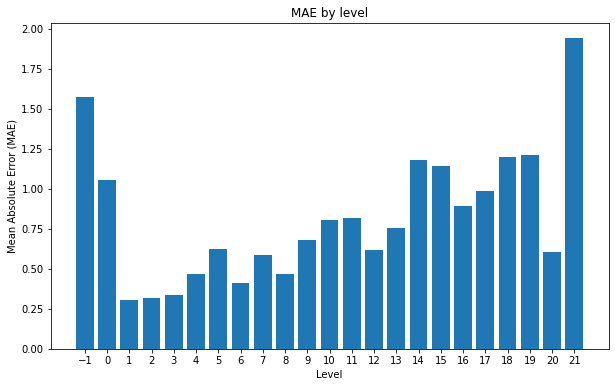

In [84]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

###### MAE by level LASSO

In [85]:
y_pred_test = reg_lasso_cv.predict(X_test)

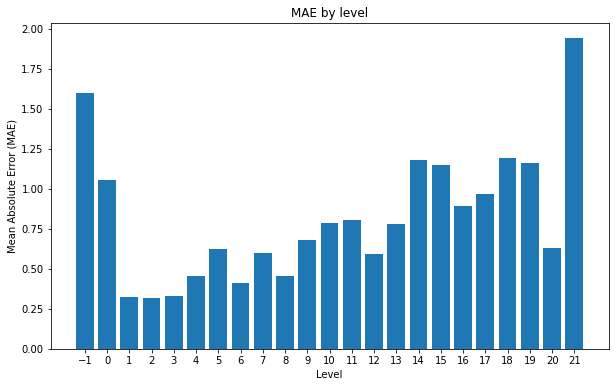

In [86]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

Index(['cha', 'con', 'dex', 'int', 'str', 'wis', 'ac', 'hp'], dtype='object')
[-0.23576368  1.08064622 -0.78079444  0.16204711 -0.05458773  0.13166086
 17.52525515 10.69664378]


<AxesSubplot:title={'center':'Best features'}, ylabel='feature name'>

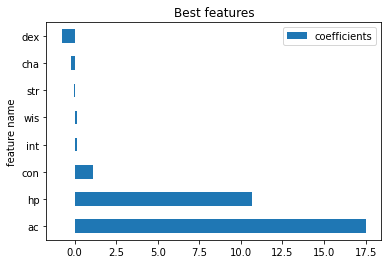

In [87]:
feature_names = X_train.columns
print(feature_names)
print(reg_ridge_cv.coef_)

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": characteristics,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(x="feature name", y="coefficients", title="Best features")

In [88]:
sorted(feature_names[reg_lasso_cv.coef_ == 0])

['int', 'str', 'wis']

### With random split

In [89]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(1e-3, 1, 10000))
reg_lasso_cv = LassoCV(alphas=np.linspace(1e-4, 1e-1, 1000), random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train_random_split, y_train_random_split)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train_random_split,
    np.array(y_train_random_split).reshape(
        y_train_random_split.size,
    ),
)

print(f"Ridge CV alphas: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
rmse, mse, mae = assess_regression_model(
    reg_ridge_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[4] = ["random", "Ridge", 8, mse, rmse, mae]

print("Lasso:")
rmse, mse, mae = assess_regression_model(
    reg_lasso_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[5] = ["random", "Lasso", 8, mse, rmse, mae]

Ridge CV alphas: 0.0311
Lasso CV alpha: 0.0008

Ridge:
R2: 0.98
RMSE train: 0.79
RMSE test: 0.83
MSE test: 0.68
MAE test: 0.54

Lasso:
R2: 0.98
RMSE train: 0.79
RMSE test: 0.82
MSE test: 0.68
MAE test: 0.54



###### MAE by level

In [90]:
y_pred_test_random_split = reg_ridge_cv.predict(X_test_random_split)

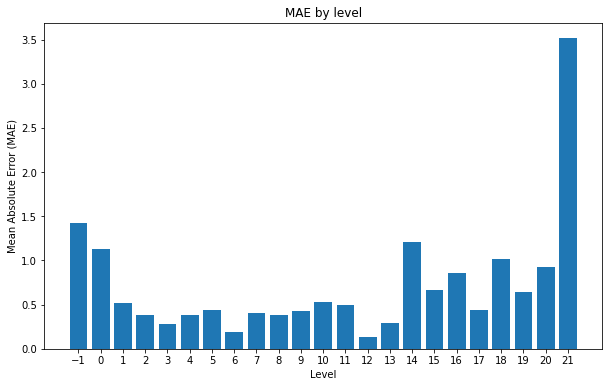

In [91]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test_random_split)[
        y_test_random_split == lvl
    ]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

###### MAE by level

In [92]:
y_pred_test_random_split = reg_lasso_cv.predict(X_test_random_split)

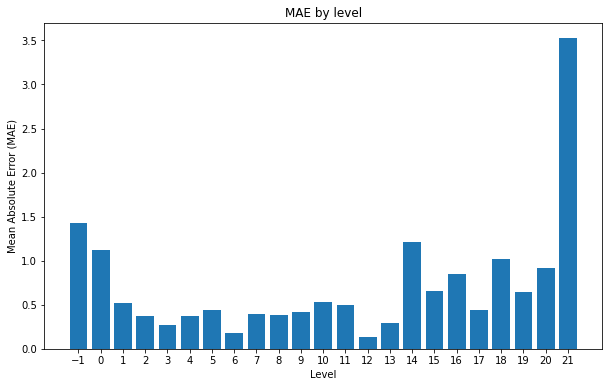

In [93]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test_random_split)[
        y_test_random_split == lvl
    ]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

Index(['cha', 'con', 'dex', 'int', 'str', 'wis', 'ac', 'hp'], dtype='object')
[-5.25797969e-01  1.18642655e+00 -6.29784647e-01  1.34157357e-01
 -1.01923671e+00  1.95668543e-03  1.86864436e+01  1.07051322e+01]


<AxesSubplot:title={'center':'Best features'}, ylabel='feature name'>

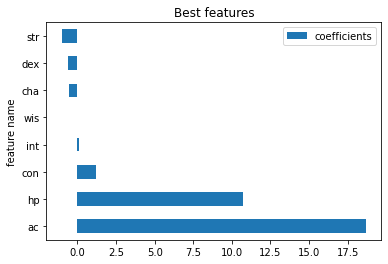

In [94]:
feature_names = X_train.columns
print(feature_names)
print(reg_ridge_cv.coef_)

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": characteristics,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(x="feature name", y="coefficients", title="Best features")

In [95]:
eliminated_features = sorted(feature_names[reg_lasso_cv.coef_ == 0])
print(eliminated_features)

['wis']


## Summary

In [96]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,0.898038,0.947648,0.673958
1,random,normal,8,0.679964,0.824599,0.538489
2,chronological,Ridge,8,0.914811,0.956457,0.677980
3,chronological,Lasso,8,0.909914,0.953894,0.677665
4,random,Ridge,8,0.680736,0.825067,0.538193
5,random,Lasso,8,0.678174,0.823513,0.535896


In [97]:
from training.results import plot_summary

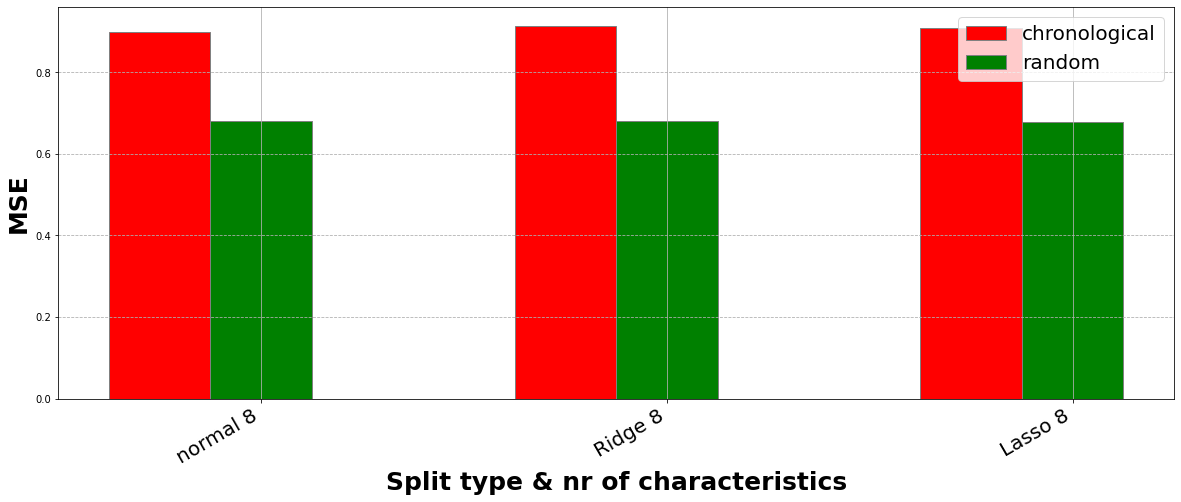

In [98]:
plot_summary(results, "MSE")

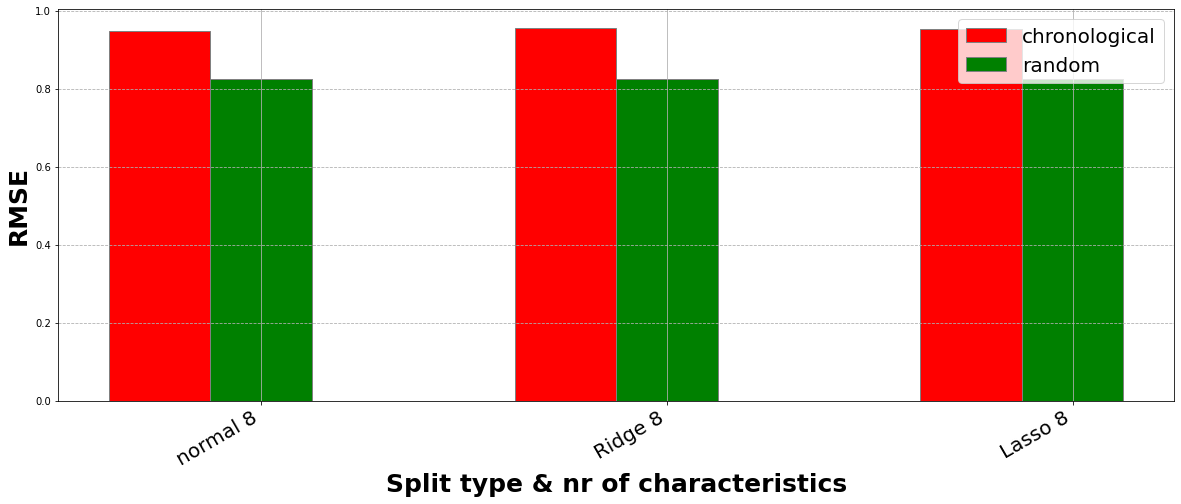

In [99]:
plot_summary(results, "RMSE")

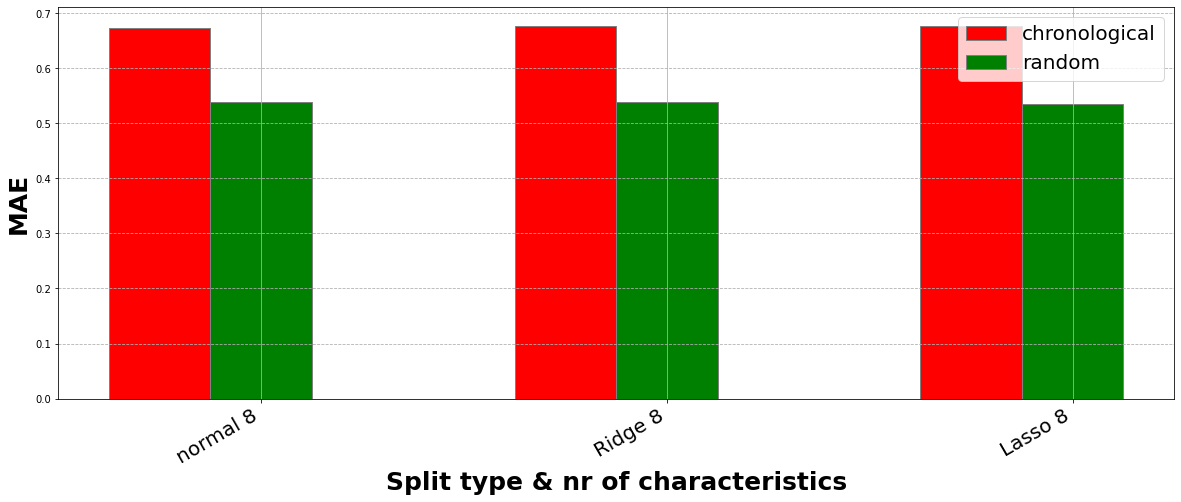

In [100]:
plot_summary(results, "MAE")

In [101]:
results.to_json("./linear_regression_basic_results.json")